# 畳み込みニューラルネット
## インポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import cv2
from sklearn.model_selection import KFold

print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


## 変数、クラス定義

In [2]:
directory_path = "D:/Work/ImageRecognition/Images/%s"
food_path = "food_142/"
flower_path = "flower_142/"
food_test_path = "food_test/"
flower_test_path = "flower_test/"
num_classes = 2

#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # ランダムにトリミングして (224, 224)の形状にしてる
        transforms.RandomHorizontalFlip(),  # 50%の確率で水平方向に反転させる
        transforms.ToTensor(),  # Tensorに変換
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 平均値と標準偏差を指定して、結果のTensorを正規化
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # 画像のサイズを(256, 256)にする
        transforms.CenterCrop(224),  # (224, 224)にするために、サイズ変更された画像を中央で切り取る
        transforms.ToTensor(),  # Tensorに変換
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 平均値と標準偏差を指定して、結果のTensorを正規化
    ]),
}
#正規化をしない前処理
to_tensor_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

def cross_validate(net, split_size=5):
  results = []
  fold = KFold(n_splits=3, shuffle=True, random_state=0)
  for train_idx, val_idx in kf.split(train_x_all, train_y_all):
    train_x = train_x_all[train_idx]
    train_y = train_y_all[train_idx]
    val_x = train_x_all[val_idx]
    val_y = train_y_all[val_idx]
    run_train(session, train_x, train_y)
    results.append(session.run(accuracy, feed_dict={x: val_x, y: val_y}))
  return results

class FoodFlowerDataset(torch.utils.data.Dataset):

    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.images = []
        self.labels = []
        if train:
            food_folder = directory_path%(food_path)
            flower_folder = directory_path%(flower_path)
        else:
            food_folder = directory_path%(food_test_path)
            flower_folder = directory_path%(flower_test_path)
        self.images.extend([food_folder + p for p in os.listdir(food_folder)])
        self.labels.extend([0] * len(self.images))
        self.images.extend([flower_folder + p for p in os.listdir(flower_folder)])
        self.labels.extend([1] * (len(self.images)-len(self.labels)))
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        with open(image, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.images)


class AlexNet(nn.Module):
    #fc_sizeを引き渡す
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        size_check = torch.FloatTensor(10, 3, 224, 224)
        fc_size = self.features(size_check).view(size_check.size(0), -1).size()[1]
        #fc_sizeで計算した形状を指定
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



## AlexNet Adam

In [7]:
net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

num_epochs = 150

Epoch [1/150], Loss: 0.0694, val_loss: 0.1423, val_acc: 0.6029
Epoch [2/150], Loss: 0.0681, val_loss: 0.1308, val_acc: 0.7647
Epoch [3/150], Loss: 0.0622, val_loss: 0.1010, val_acc: 0.7500
Epoch [4/150], Loss: 0.0578, val_loss: 0.1083, val_acc: 0.7059
Epoch [5/150], Loss: 0.0521, val_loss: 0.1064, val_acc: 0.7647
Epoch [6/150], Loss: 0.0439, val_loss: 0.1037, val_acc: 0.7353
Epoch [7/150], Loss: 0.0431, val_loss: 0.0905, val_acc: 0.7794
Epoch [8/150], Loss: 0.0449, val_loss: 0.0824, val_acc: 0.8088
Epoch [9/150], Loss: 0.0371, val_loss: 0.0820, val_acc: 0.7941
Epoch [10/150], Loss: 0.0348, val_loss: 0.0847, val_acc: 0.7794
Epoch [11/150], Loss: 0.0272, val_loss: 0.1002, val_acc: 0.8529
Epoch [12/150], Loss: 0.0320, val_loss: 0.0857, val_acc: 0.7794
Epoch [13/150], Loss: 0.0358, val_loss: 0.0801, val_acc: 0.8088
Epoch [14/150], Loss: 0.0291, val_loss: 0.0882, val_acc: 0.8235
Epoch [15/150], Loss: 0.0269, val_loss: 0.0916, val_acc: 0.8235
Epoch [16/150], Loss: 0.0319, val_loss: 0.0993, v

Epoch [129/150], Loss: 0.0088, val_loss: 0.0667, val_acc: 0.9118
Epoch [130/150], Loss: 0.0180, val_loss: 0.0679, val_acc: 0.8382
Epoch [131/150], Loss: 0.0103, val_loss: 0.0962, val_acc: 0.8235
Epoch [132/150], Loss: 0.0089, val_loss: 0.0556, val_acc: 0.9118
Epoch [133/150], Loss: 0.0088, val_loss: 0.0802, val_acc: 0.8382
Epoch [134/150], Loss: 0.0126, val_loss: 0.0521, val_acc: 0.9412
Epoch [135/150], Loss: 0.0096, val_loss: 0.0745, val_acc: 0.8529
Epoch [136/150], Loss: 0.0076, val_loss: 0.0718, val_acc: 0.8676
Epoch [137/150], Loss: 0.0058, val_loss: 0.0649, val_acc: 0.8676
Epoch [138/150], Loss: 0.0034, val_loss: 0.0586, val_acc: 0.8676
Epoch [139/150], Loss: 0.0100, val_loss: 0.0588, val_acc: 0.9265
Epoch [140/150], Loss: 0.0090, val_loss: 0.0543, val_acc: 0.8824
Epoch [141/150], Loss: 0.0151, val_loss: 0.0572, val_acc: 0.8676
Epoch [142/150], Loss: 0.0056, val_loss: 0.0660, val_acc: 0.8971
Epoch [143/150], Loss: 0.0085, val_loss: 0.0590, val_acc: 0.8824
Epoch [144/150], Loss: 0.

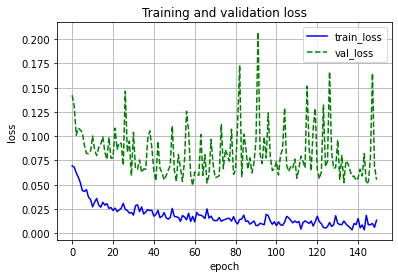

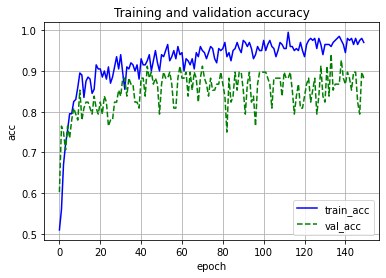

In [8]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# 定義したDatasetとDataLoaderを使用
train_dataset = FoodFlowerDataset(data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=10, 
                                           shuffle=True)
valuation_dataset = FoodFlowerDataset(data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=5, 
                                           shuffle=False)

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
      for images, labels in valuation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## AlexNet SGD

In [5]:
net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 300

Epoch [1/300], Loss: 0.0695, val_loss: 0.1425, val_acc: 0.5294
Epoch [2/300], Loss: 0.0694, val_loss: 0.1428, val_acc: 0.4706
Epoch [3/300], Loss: 0.0697, val_loss: 0.1421, val_acc: 0.5294
Epoch [4/300], Loss: 0.0693, val_loss: 0.1430, val_acc: 0.4706
Epoch [5/300], Loss: 0.0693, val_loss: 0.1427, val_acc: 0.4706
Epoch [6/300], Loss: 0.0695, val_loss: 0.1426, val_acc: 0.4706
Epoch [7/300], Loss: 0.0691, val_loss: 0.1415, val_acc: 0.5882
Epoch [8/300], Loss: 0.0687, val_loss: 0.1396, val_acc: 0.7353
Epoch [9/300], Loss: 0.0671, val_loss: 0.1308, val_acc: 0.7500
Epoch [10/300], Loss: 0.0634, val_loss: 0.1242, val_acc: 0.7206
Epoch [11/300], Loss: 0.0612, val_loss: 0.1161, val_acc: 0.6765
Epoch [12/300], Loss: 0.0519, val_loss: 0.1195, val_acc: 0.7500
Epoch [13/300], Loss: 0.0582, val_loss: 0.1021, val_acc: 0.7794
Epoch [14/300], Loss: 0.0533, val_loss: 0.1324, val_acc: 0.5294
Epoch [15/300], Loss: 0.0554, val_loss: 0.0988, val_acc: 0.8235
Epoch [16/300], Loss: 0.0872, val_loss: 0.1449, v

Epoch [129/300], Loss: 0.0192, val_loss: 0.0650, val_acc: 0.8676
Epoch [130/300], Loss: 0.0183, val_loss: 0.0707, val_acc: 0.8529
Epoch [131/300], Loss: 0.0174, val_loss: 0.0963, val_acc: 0.8235
Epoch [132/300], Loss: 0.0118, val_loss: 0.0522, val_acc: 0.9118
Epoch [133/300], Loss: 0.0138, val_loss: 0.0942, val_acc: 0.8676
Epoch [134/300], Loss: 0.0077, val_loss: 0.0621, val_acc: 0.8971
Epoch [135/300], Loss: 0.0155, val_loss: 0.1567, val_acc: 0.8088
Epoch [136/300], Loss: 0.0146, val_loss: 0.1520, val_acc: 0.7941
Epoch [137/300], Loss: 0.0198, val_loss: 0.0725, val_acc: 0.8824
Epoch [138/300], Loss: 0.0150, val_loss: 0.0449, val_acc: 0.9118
Epoch [139/300], Loss: 0.0128, val_loss: 0.0567, val_acc: 0.8971
Epoch [140/300], Loss: 0.0335, val_loss: 0.0497, val_acc: 0.9118
Epoch [141/300], Loss: 0.0250, val_loss: 0.0558, val_acc: 0.9118
Epoch [142/300], Loss: 0.0272, val_loss: 0.0548, val_acc: 0.8824
Epoch [143/300], Loss: 0.0193, val_loss: 0.0525, val_acc: 0.8824
Epoch [144/300], Loss: 0.

Epoch [256/300], Loss: 0.0116, val_loss: 0.0640, val_acc: 0.9118
Epoch [257/300], Loss: 0.0116, val_loss: 0.0788, val_acc: 0.8382
Epoch [258/300], Loss: 0.0069, val_loss: 0.0405, val_acc: 0.9412
Epoch [259/300], Loss: 0.0065, val_loss: 0.0351, val_acc: 0.9412
Epoch [260/300], Loss: 0.0183, val_loss: 0.1014, val_acc: 0.8382
Epoch [261/300], Loss: 0.0165, val_loss: 0.0754, val_acc: 0.8382
Epoch [262/300], Loss: 0.0157, val_loss: 0.0365, val_acc: 0.9412
Epoch [263/300], Loss: 0.0115, val_loss: 0.0488, val_acc: 0.8676
Epoch [264/300], Loss: 0.0073, val_loss: 0.0367, val_acc: 0.9118
Epoch [265/300], Loss: 0.0123, val_loss: 0.0341, val_acc: 0.9265
Epoch [266/300], Loss: 0.0239, val_loss: 0.0319, val_acc: 0.9265
Epoch [267/300], Loss: 0.0112, val_loss: 0.0553, val_acc: 0.9118
Epoch [268/300], Loss: 0.0070, val_loss: 0.0574, val_acc: 0.8824
Epoch [269/300], Loss: 0.0114, val_loss: 0.0508, val_acc: 0.8971
Epoch [270/300], Loss: 0.0090, val_loss: 0.0443, val_acc: 0.9412
Epoch [271/300], Loss: 0.

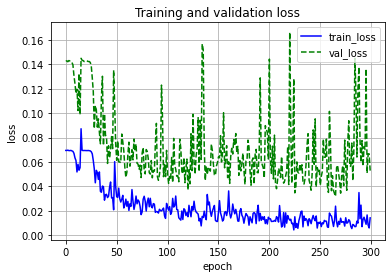

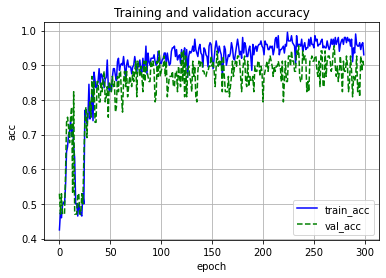

In [6]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# 定義したDatasetとDataLoaderを使用
train_dataset = FoodFlowerDataset(data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=10, 
                                           shuffle=True)
valuation_dataset = FoodFlowerDataset(data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=5, 
                                           shuffle=False)

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
      for images, labels in valuation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()